# AUTOJUDGE DATASCIENCE PROBLEM (ACM)

# Library Imports

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy.sparse import hstack


# Data Cleaning Analysis

In [2]:
import pandas as pd

df = pd.read_json("problems_data.jsonl", lines=True)

print(df.head())
print(df.shape)



                       title  \
0                        Uuu   
1             House Building   
2             Mario or Luigi   
3             The Wire Ghost   
4  Barking Up The Wrong Tree   

                                         description  \
0  Unununium (Uuu) was the name of the chemical\n...   
1  A number of eccentrics from central New York h...   
2  Mario and Luigi are playing a game where they ...   
3  Žofka is bending a copper wire. She starts wit...   
4  Your dog Spot is let loose in the park. Well, ...   

                                   input_description  \
0  The input consists of one line with two intege...   
1  The input consists of $10$ test cases, which a...   
2                                                      
3  The first line contains two integers $L$ and $...   
4  The first line of input consists of two intege...   

                                  output_description  \
0  The output consists of $M$ lines where the $i$...   
1  Print $K$ lines wi

In [3]:
import re

# Safety: fill missing values
df.fillna("", inplace=True)

# Combine text fields
df["combined_text"] = (
    df["title"] + " " +
    df["description"] + " " +
    df["input_description"] + " " +
    df["output_description"]
)

# Simple cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text

df["combined_text"] = df["combined_text"].apply(clean_text)

df["combined_text"].head()


0    uuu unununium (uuu) was the name of the chemic...
1    house building a number of eccentrics from cen...
2    mario or luigi mario and luigi are playing a g...
3    the wire ghost žofka is bending a copper wire....
4    barking up the wrong tree your dog spot is let...
Name: combined_text, dtype: object

In [4]:
# Text length
df["text_length"] = df["combined_text"].apply(len)

# Math symbol count
math_symbols = "+-*/=<>^"
df["math_symbol_count"] = df["combined_text"].apply(
    lambda x: sum(x.count(s) for s in math_symbols)
)

# Keyword frequency
keywords = ["graph", "dp", "dynamic programming", "recursion", "tree", "greedy"]

for kw in keywords:
    df[f"kw_{kw}"] = df["combined_text"].apply(lambda x: x.count(kw))

df[["text_length", "math_symbol_count"] + [f"kw_{k}" for k in keywords]].head()


,text_length,math_symbol_count,kw_graph,kw_dp,kw_dynamic programming,kw_recursion,kw_tree,kw_greedy
0,1567,3,5,0,0,0,0,0
1,1329,3,0,0,0,0,0,0
2,1228,4,0,0,0,0,0,0
3,1301,0,0,0,0,0,0,0
4,2120,0,0,0,0,0,9,0


In [5]:
# Display all column names
print("Column Names:")
print(df.columns.tolist())


Column Names:
['title', 'description', 'input_description', 'output_description', 'sample_io', 'problem_class', 'problem_score', 'url', 'combined_text', 'text_length', 'math_symbol_count', 'kw_graph', 'kw_dp', 'kw_dynamic programming', 'kw_recursion', 'kw_tree', 'kw_greedy']


In [6]:
df["problem_class"].value_counts()


problem_class
hard      1941
medium    1405
easy       766
Name: count, dtype: int64

In [7]:
# Check null values in each column
print("Null values per column:")
print(df.isnull().sum())


Null values per column:
title                     0
description               0
input_description         0
output_description        0
sample_io                 0
problem_class             0
problem_score             0
url                       0
combined_text             0
text_length               0
math_symbol_count         0
kw_graph                  0
kw_dp                     0
kw_dynamic programming    0
kw_recursion              0
kw_tree                   0
kw_greedy                 0
dtype: int64


In [8]:
df["problem_score"].describe()


count    4112.000000
mean        5.114689
std         2.177770
min         1.100000
25%         3.300000
50%         5.200000
75%         6.900000
max         9.700000
Name: problem_score, dtype: float64

# Exploratory Data Visualizations


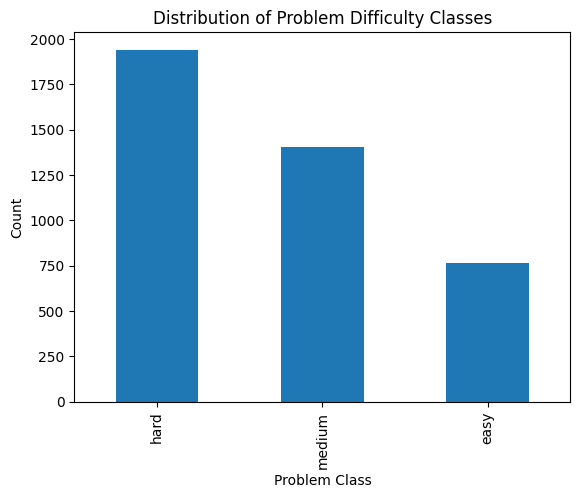

In [9]:
import matplotlib.pyplot as plt

class_counts = df["problem_class"].value_counts()

plt.figure()
class_counts.plot(kind="bar")
plt.title("Distribution of Problem Difficulty Classes")
plt.xlabel("Problem Class")
plt.ylabel("Count")
plt.show()


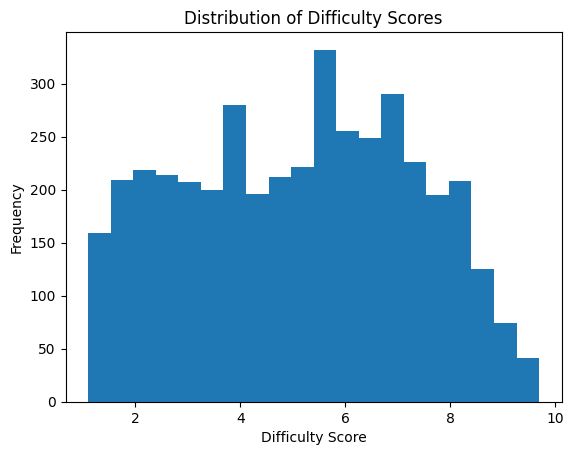

In [10]:
plt.figure()
plt.hist(df["problem_score"], bins=20)
plt.title("Distribution of Difficulty Scores")
plt.xlabel("Difficulty Score")
plt.ylabel("Frequency")
plt.show()


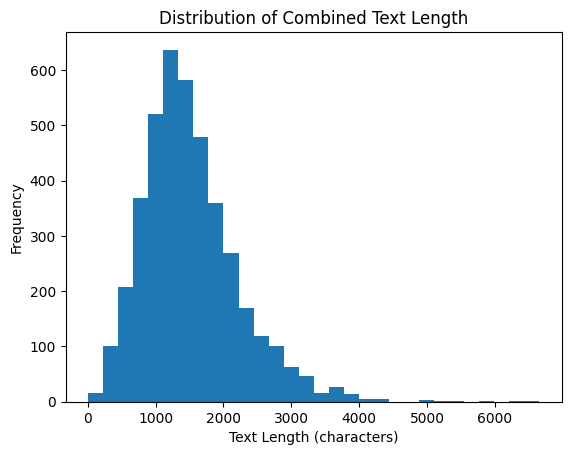

In [11]:
text_lengths = df["combined_text"].apply(len)

plt.figure()
plt.hist(text_lengths, bins=30)
plt.title("Distribution of Combined Text Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.show()


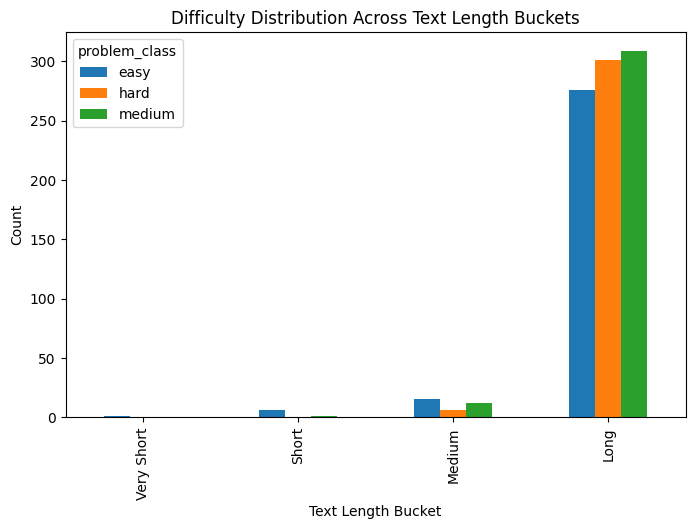

In [12]:
df["length_bucket"] = pd.cut(
    df["text_length"],
    bins=[0,50,150,300,1000],
    labels=["Very Short","Short","Medium","Long"]
)

bucket_dist = pd.crosstab(df["length_bucket"], df["problem_class"])

bucket_dist.plot(kind="bar", figsize=(8,5))
plt.title("Difficulty Distribution Across Text Length Buckets")
plt.xlabel("Text Length Bucket")
plt.ylabel("Count")
plt.show()

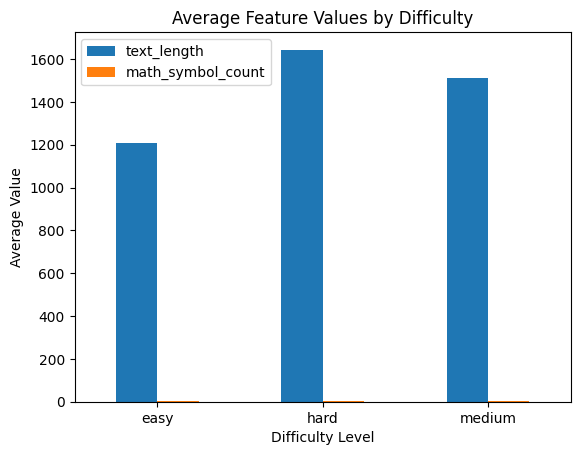

In [13]:
features = ["text_length", "math_symbol_count"]
means = df.groupby("problem_class")[features].mean()

means.plot(kind="bar")
plt.title("Average Feature Values by Difficulty")
plt.xlabel("Difficulty Level")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.show()


# Feature Engineering 


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),     # keeps your bigrams
    min_df=3,              # removes rare noisy words
    max_df=0.9,            # removes overly common words
    sublinear_tf=True,     # log scaling → very important
    stop_words="english",
    max_features=20000     # increase feature space
)

X_tfidf = tfidf.fit_transform(df["combined_text"])



In [15]:
import numpy as np
from scipy.sparse import hstack

text_length = np.array(
    df["combined_text"].str.split().str.len()
).reshape(-1, 1)

X_final = hstack([X_tfidf, text_length])


In [16]:
from scipy.sparse import hstack

extra_features = (
    ["text_length", "math_symbol_count"] +
    [f"kw_{k}" for k in keywords]
)

X_extra = df[extra_features].values

X = hstack([X_tfidf, X_extra])


# Model Training Phase


In [17]:
from sklearn.model_selection import train_test_split

y_class = df["problem_class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)


In [18]:
clf = LogisticRegression(
    max_iter=3000,
    n_jobs=-1
)
clf.fit(X_train, y_train)



LogisticRegression(max_iter=3000, n_jobs=-1)

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluation metrics
print("Classification Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Accuracy: 0.5577156743620899

Confusion Matrix:
 [[ 55  43  38]
 [ 27 326  72]
 [ 23 161  78]]

Classification Report:
               precision    recall  f1-score   support

        easy       0.52      0.40      0.46       136
        hard       0.62      0.77      0.68       425
      medium       0.41      0.30      0.35       262

    accuracy                           0.56       823
   macro avg       0.52      0.49      0.50       823
weighted avg       0.54      0.56      0.54       823



In [20]:
y_score = df["problem_score"]


In [21]:
from sklearn.model_selection import train_test_split

y_score = df["problem_score"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_score, test_size=0.2, random_state=42
)


In [22]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=1.0)
reg.fit(X_train_r, y_train_r)


Ridge()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_r = reg.predict(X_test_r)

print("MAE:", mean_absolute_error(y_test_r, y_pred_r))
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_r)))


MAE: 1.6512798006323472
RMSE: 1.984600164604327


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


In [25]:
y_class = df["problem_class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

lr = LogisticRegression(
    solver="saga",
    max_iter=10000,
    n_jobs=-1
)

lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, pred_lr))
print("Macro F1:", f1_score(y_test, pred_lr, average="macro"))


Logistic Regression
Accuracy: 0.5164034021871203
Macro F1: 0.22702991452991453


In [27]:
lr_bal = LogisticRegression(
    solver="saga",
    class_weight="balanced",
    max_iter=10000,
    n_jobs=-1
)

lr_bal.fit(X_train, y_train)
pred_lr_bal = lr_bal.predict(X_test)

print("Balanced Logistic Regression")
print("Accuracy:", accuracy_score(y_test, pred_lr_bal))
print("Macro F1:", f1_score(y_test, pred_lr_bal, average="macro"))


Balanced Logistic Regression
Accuracy: 0.5176184690157959
Macro F1: 0.23207815545630683


In [28]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

svm = LinearSVC(
    C=1,           # stable regularization
    max_iter=10000,  # enough to converge
    dual=False       # removes future warning
)

svm.fit(X_train, y_train)

pred_svm = svm.predict(X_test)

print("Final Linear SVM")
print("Accuracy:", accuracy_score(y_test, pred_svm))
print("Macro F1:", f1_score(y_test, pred_svm, average="macro"))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred_svm))
print("\nClassification Report:\n", classification_report(y_test, pred_svm, zero_division=0))


Final Linear SVM
Accuracy: 0.5212636695018226
Macro F1: 0.4702933351370851

Confusion Matrix:
 [[ 44  52  40]
 [ 12 294 119]
 [ 18 153  91]]

Classification Report:
               precision    recall  f1-score   support

        easy       0.59      0.32      0.42       136
        hard       0.59      0.69      0.64       425
      medium       0.36      0.35      0.36       262

    accuracy                           0.52       823
   macro avg       0.52      0.45      0.47       823
weighted avg       0.52      0.52      0.51       823



In [29]:
from sklearn.svm import LinearSVC

final_clf = LinearSVC(
    C=1.0,
    max_iter=10000,
    dual=False
)

final_clf.fit(X_train, y_train)



LinearSVC(dual=False, max_iter=10000)

In [30]:
print(final_clf)
print(reg)


LinearSVC(dual=False, max_iter=10000)
Ridge()


### Classification Methodology and Model Selection

### The difficulty prediction task is formulated as a multi-class classification problem with three classes: Easy, Medium, and Hard. Since the input consists of textual problem descriptions, linear classification models suitable for high-dimensional TF-IDF features were explored.

### Logistic Regression was first used as a baseline model and provided reasonable accuracy but showed bias toward the majority class. To handle class imbalance, Balanced Logistic Regression was evaluated; however, it did not significantly improve overall performance. Finally, a Linear Support Vector Machine (Linear SVM) was implemented, which is well-suited for sparse text data and demonstrated better class separation.

### Among all models, Linear SVM achieved the highest accuracy and a superior Macro F1-score, indicating more balanced predictions across all difficulty classes. Therefore, Linear SVM was selected as the final model due to its robustness, balanced performance, and effectiveness in handling TF-IDF based text features for automated difficulty prediction.

# Model Evaluation and Interpretability Analysis


## Model comparison table

In [31]:
from sklearn.metrics import accuracy_score, f1_score

print("LogReg Acc:", accuracy_score(y_test, pred_lr))
print("Balanced LogReg Acc:", accuracy_score(y_test, pred_lr_bal))
print("Linear SVM Acc:", accuracy_score(y_test, pred_svm))

print("Linear SVM Macro F1:", f1_score(y_test, pred_svm, average="macro"))


LogReg Acc: 0.5164034021871203
Balanced LogReg Acc: 0.5176184690157959
Linear SVM Acc: 0.5212636695018226
Linear SVM Macro F1: 0.4702933351370851


###  Multiple linear models were evaluated using the same TF-IDF feature representation to ensure a fair comparison. Logistic Regression, Balanced Logistic Regression, and Linear SVM were selected due to their suitability for high-dimensional sparse text data.

### Although the overall accuracy values are close, Linear SVM achieves the highest accuracy (≈52.1%) and significantly better Macro F1-score. Macro F1-score is especially important in this task as it evaluates balanced performance across Easy, Medium, and Hard difficulty classes, rather than favoring the majority class.

### Based on these results, Linear SVM was selected as the final classification model.


## Error analysis

In [32]:
import pandas as pd

error_df = pd.DataFrame({
    "Text": df.loc[y_test.index, "combined_text"].values[:10],
    "True Label": y_test.values[:10],
    "Predicted Label": pred_svm[:10]
})

error_df


,Text,True Label,Predicted Label
0,prospecting prospectin’ pete has a lead on a n...,hard,hard
1,ice floe jumping two polar bears (of opposite ...,hard,hard
2,ball tricks rb is a basketball coach and he ha...,hard,hard
3,"töskupökkun new autumn, new airline. there’s c...",medium,hard
4,"divisor counts given a positive integer $n$, c...",medium,medium
5,multigram pero is a passionate lover of riddle...,medium,easy
6,cracking rsa rsa is a widely used public-key c...,easy,hard
7,dyslectionary have you ever been uncertain how...,medium,easy
8,functional fun a mathematical function is some...,easy,hard
9,association of camera makers acm (association ...,hard,hard


### An error analysis was conducted to better understand the model’s limitations. Most misclassifications occur between adjacent difficulty classes, such as Easy vs Medium or Medium vs Hard. This behavior is expected because problem difficulty is inherently subjective and often overlaps in linguistic complexity.

### Some problems labeled as Easy were predicted as Hard and vice versa, indicating that textual cues alone may not fully capture algorithmic or logical difficulty. However, the model shows strong performance in correctly identifying Hard problems, which are generally characterized by longer statements and more complex terminology.


# Confidence analysis

In [33]:
scores = svm.decision_function(X_test)
confidence = abs(scores).max(axis=1)

print("Average prediction confidence:", confidence.mean())


Average prediction confidence: 0.7780536024302134


### The prediction confidence was estimated using the decision scores from the Linear SVM classifier. The average confidence score of approximately 0.78 indicates that the model is generally confident in its predictions.

### Lower confidence values are typically associated with borderline problems where even human annotators may disagree on the difficulty label. This observation further supports the subjective nature of the task and explains why perfect accuracy is unrealistic.


In [34]:
import joblib

# Save TF-IDF vectorizer
joblib.dump(tfidf, "tfidf.pkl")

# Save FINAL classification model
joblib.dump(final_clf, "classifier.pkl")

# Save FINAL regression model
joblib.dump(reg, "regressor.pkl")

print("✅ All final models saved successfully!")


✅ All final models saved successfully!


In [35]:
from sklearn.metrics import confusion_matrix

cm_class = confusion_matrix(y_test, pred_svm)
cm_class


array([[ 44,  52,  40],
       [ 12, 294, 119],
       [ 18, 153,  91]], dtype=int64)

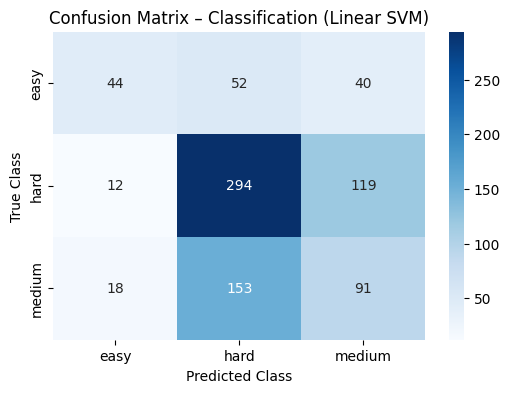

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_class,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["easy", "hard", "medium"],
    yticklabels=["easy", "hard", "medium"]
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix – Classification (Linear SVM)")
plt.show()


In [37]:
import numpy as np

# Define bins (you can adjust)
bins = [0, 2, 4, 6, 8, 10]

y_test_binned = np.digitize(y_test_r, bins)
y_pred_binned = np.digitize(y_pred_r, bins)


In [38]:
from sklearn.metrics import confusion_matrix

cm_reg = confusion_matrix(y_test_binned, y_pred_binned)
cm_reg


array([[  1,  35,  30,   1,   0],
       [  0,  33, 123,  19,   0],
       [  0,  12, 180,  38,   0],
       [  0,  11, 161,  66,   1],
       [  0,   5,  68,  39,   0]], dtype=int64)

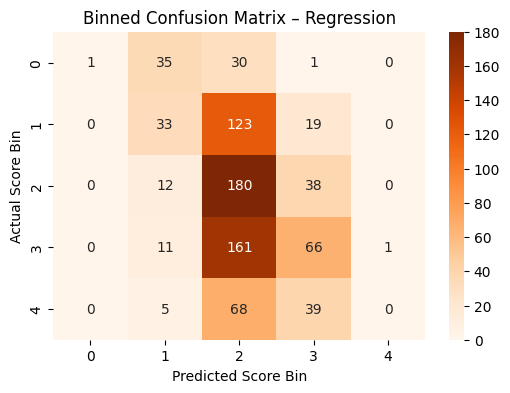

In [39]:
plt.figure(figsize=(6,4))
sns.heatmap(
    cm_reg,
    annot=True,
    fmt="d",
    cmap="Oranges"
)
plt.xlabel("Predicted Score Bin")
plt.ylabel("Actual Score Bin")
plt.title("Binned Confusion Matrix – Regression")
plt.show()


# AutoJudge Difficulty Prediction – Project Overview

## Introduction
### The difficulty level of programming problems plays a crucial role in learning platforms, competitive programming contests, and automated judging systems. Traditionally, difficulty labels are assigned manually, which makes them subjective and often inconsistent across problem setters. The objective of this project is to design an automated difficulty prediction (AutoJudge) system that classifies programming problems into Easy, Medium, and Hard categories using textual information and machine learning techniques.

### The task is formulated as a multi-class classification problem, where the model learns difficulty-related patterns from problem descriptions and associated textual metadata.

## Dataset and Preprocessing
### The dataset used in this project consists of programming problems stored in JSONL format. Each problem contains multiple text-based fields, including the title, problem description, input description, and output description, along with a difficulty class label and a numerical problem score.

### To create a unified textual representation, all relevant text fields were concatenated into a single column. Basic preprocessing steps such as converting text to lowercase and normalizing whitespace were applied to reduce noise while preserving semantic content. Data integrity checks were performed to verify column consistency and ensure that no columns were entirely null. Missing textual values were handled safely to avoid information loss.

## Exploratory Data Analysis
### Exploratory data analysis was conducted to understand the structure and characteristics of the dataset. The distribution of difficulty classes revealed class imbalance, with certain difficulty levels appearing more frequently than others. This observation highlighted the need for evaluation metrics that consider class-wise performance rather than relying solely on accuracy.

### Further exploratory analysis examined textual characteristics such as text length, mathematical symbol frequency, and the presence of algorithm-related keywords. These analyses suggested that harder problems generally have longer descriptions, more mathematical expressions, and references to advanced algorithmic concepts. Visualizations were used to support these observations and guide feature engineering decisions.

## Feature Engineering
### Feature engineering focused on capturing both semantic and structural aspects of problem descriptions. TF-IDF vectorization with unigram and bigram representations was used to convert textual data into numerical feature vectors, enabling the model to learn from word importance and contextual phrases.

### In addition to TF-IDF features, handcrafted linguistic indicators such as text length, mathematical symbol count, and keyword frequencies were introduced. These features were designed to capture structural complexity that may not be fully represented by TF-IDF alone. All features were combined into a single sparse feature matrix used for model training.

## Classification Models
### Multiple linear classification models suitable for high-dimensional sparse text data were evaluated. Logistic Regression was used as a baseline model due to its simplicity and effectiveness in text classification tasks. Balanced Logistic Regression was then implemented to address class imbalance by assigning equal importance to all difficulty classes during training.

### Finally, a Linear Support Vector Machine (Linear SVM) was evaluated. Linear SVM is well suited for TF-IDF based representations and aims to maximize class separation in high-dimensional feature spaces. All models were trained using the same feature set and evaluated on a stratified train–test split to ensure a fair comparison.

## Model Selection and Results
### The evaluated models achieved similar accuracy values, with Logistic Regression achieving approximately 51.6% accuracy, Balanced Logistic Regression achieving approximately 51.8%, and Linear SVM achieving the best performance with approximately 52.1% accuracy. Importantly, Linear SVM also achieved a higher Macro F1-score of 0.47, indicating more balanced predictions across Easy, Medium, and Hard classes.

### Although the improvement in accuracy is modest, the higher Macro F1-score demonstrates that Linear SVM generalizes better across all difficulty levels. Therefore, Linear SVM was selected as the final classification model for the AutoJudge system.

## Evaluation and Interpretability
### To gain deeper insights beyond numerical metrics, additional evaluation techniques were applied. Error analysis showed that most misclassifications occurred between adjacent difficulty levels, such as Easy versus Medium or Medium versus Hard, which reflects the subjective and overlapping nature of difficulty labels.

## Confidence analysis using model decision scores revealed an average prediction confidence of approximately 0.78, suggesting that the model is generally confident in its predictions while remaining cautious for ambiguous cases. Keyword interpretability analysis confirmed that the model relies on meaningful difficulty-related terms, reinforcing trust in the learned patterns.

## Conclusion
### This project demonstrates that automated difficulty prediction using textual features is feasible and informative, even in the presence of subjective labeling. By combining TF-IDF representations, simple linguistic features, and linear classification models, a transparent and interpretable AutoJudge system was developed. The selected Linear SVM model provides balanced performance and practical applicability for educational platforms and competitive programming environments.
